This notebook is very similar to `class_sz_CIB.ipynb`. Refer to that notebook for CIB autospectrum with `class_sz`.

In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
from classy_sz import Class
import os
import time

font = {'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

2023-12-01 23:42:16.218114: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-01 23:42:16.218134: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-01 23:42:16.218140: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-01 23:42:16.218174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-01 23:42:16.218190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# a simple conversion from cl's to dl's
def cl_to_dl(lp):
    return lp*(lp+1.)/2./np.pi

# CIB x $\kappa$ Power Spectrum

## Set Parameters

You can set `class_sz` parameters individually, in a single dictionary, or multiple dictionaries.

First, let's establish the cosmology. McCarthy et al. use Planck 2014 cosmology (https://arxiv.org/pdf/1303.5076.pdf, best-fit).

In [1]:
#Parameters for Cosmology Planck 14, https://arxiv.org/pdf/1303.5076.pdf, best-fit
p14_dict={}
p14_dict['h'] = 0.6711      
p14_dict['omega_b'] = 0.022068
p14_dict['Omega_cdm'] = 0.3175-0.022068/0.6711/0.6711
p14_dict['A_s'] = 2.2e-9
p14_dict['n_s'] = .9624
p14_dict['k_pivot'] = 0.05
p14_dict['tau_reio'] = 0.0925
p14_dict['N_ncdm'] = 1
p14_dict['N_ur'] = 0.00641
p14_dict['deg_ncdm'] = 3
p14_dict['m_ncdm'] = 0.02
p14_dict['T_ncdm'] = 0.71611

Halo Model and grid parameters:

In [2]:
p_hm_dict = {}

p_hm_dict['mass function'] = 'T10'
p_hm_dict['concentration parameter'] = 'D08'
p_hm_dict['delta for cib'] = '200m'
p_hm_dict['hm_consistency'] = 1
p_hm_dict['damping_1h_term'] = 0
# Precision
p_hm_dict['pressure_profile_epsabs'] = 1.e-8
p_hm_dict['pressure_profile_epsrel'] = 1.e-3
# HOD parameters for CIB
p_hm_dict['M_min_HOD'] = pow(10.,10)  # was M_min_HOD_cib

#Grid Parameters
# Mass bounds
p_hm_dict['M_min'] = 1e8 * p14_dict['h']    # was M_min_cib
p_hm_dict['M_max'] = 1e16 * p14_dict['h']   # was M_max_cib
# Redshift bounds
p_hm_dict['z_min'] = 0.07
p_hm_dict['z_max'] = 6. # fiducial for MM20 : 6
p_hm_dict['freq_min'] = 10.
p_hm_dict['freq_max'] = 5e4 
p_hm_dict['z_max_pk'] = p_hm_dict['z_max']

#Precision Parameters
# Precision for redshift integal
p_hm_dict['redshift_epsabs'] = 1e-40#1.e-40
p_hm_dict['redshift_epsrel'] = 1e-4#1.e-10 # fiducial value 1e-8
# Precision for mass integal
p_hm_dict['mass_epsabs'] = 1e-40 #1.e-40
p_hm_dict['mass_epsrel'] = 1e-4#1e-10
# Precision for Luminosity integral (sub-halo mass function)
p_hm_dict['L_sat_epsabs'] = 1e-40 #1.e-40
p_hm_dict['L_sat_epsrel'] = 1e-3#1e-10
# Multipole array
p_hm_dict['dlogell'] = 0.1
p_hm_dict['ell_max'] = 8000.
p_hm_dict['ell_min'] = 10

CIB Model parameters (see McCarthy et al. at https://journals.aps.org/prd/abstract/10.1103/PhysRevD.103.103515):

In [3]:
#CIB Parameters
p_CIB_dict = {}
p_CIB_dict['Redshift evolution of dust temperature'] =  0.36
p_CIB_dict['Dust temperature today in Kelvins'] = 24.4
p_CIB_dict['Emissivity index of sed'] = 1.75
p_CIB_dict['Power law index of SED at high frequency'] = 1.7
p_CIB_dict['Redshift evolution of L − M normalisation'] = 3.6
p_CIB_dict['Most efficient halo mass in Msun'] = 10**12.6
p_CIB_dict['Normalisation of L − M relation in [Jy MPc2/Msun]'] = 6.4e-8
p_CIB_dict['Size of of halo masses sourcing CIB emission'] = 0.5

Select your frequencies. Here, we choose some Planck frequencies. Note that the frequency lists (both for the observed CIB frequencies and the flux cuts) must be a single string, not a list of strings.

In [4]:
nu_list = [353,545,857]
nu_list_str = str(nu_list)[1:-1]  # Note: this must be a single string, not a list of strings!

#Frequency Parameters
p_freq_dict = {}
p_freq_dict['cib_frequency_list_num'] = len(nu_list)
p_freq_dict['cib_frequency_list_in_GHz'] = nu_list_str

We choose flux cuts from Planck 2013 (see https://journals.aps.org/prd/abstract/10.1103/PhysRevD.103.103515).

In [5]:
#Flux Cuts
cib_fcut_dict = {}

#Planck flux cut, Table 1 in https://arxiv.org/pdf/1309.0382.pdf
cib_fcut_dict['100'] = 400
cib_fcut_dict['143'] = 350
cib_fcut_dict['217'] = 225
cib_fcut_dict['353'] = 315
cib_fcut_dict['545'] = 350
cib_fcut_dict['857'] = 710
cib_fcut_dict['3000'] = 1000

def make_flux_cut_list(cib_flux, nu_list):
    """
    Make a string of flux cut values for given frequency list to pass into class_sz
    Beware: if frequency not in the flux_cut dictionary, it assigns 0
    """
    cib_flux_list = []
    keys = list(cib_flux.keys())
    for i,nu in enumerate(nu_list):
        if str(nu) in keys:
            cib_flux_list.append(cib_flux[str(nu)])
        else:
            cib_flux_list.append(0)
    return cib_flux_list

cib_flux_list = make_flux_cut_list(cib_fcut_dict, nu_list)

#Add Flux Cuts
p_freq_dict['cib_Snu_cutoff_list [mJy]'] = str(list(cib_flux_list))[1:-1]
p_freq_dict['has_cib_flux_cut'] = 1


## Compute Power Spectrum

### Standard `class_sz` computation

In [9]:
M = Class()

#Set Parameters
M.set(p14_dict)
M.set(p_hm_dict)
M.set(p_CIB_dict)
M.set(p_freq_dict)

#Tell It What You Want
M.set({
    'output': 'lens_cib_1h,lens_cib_2h'
})

True

In [10]:
%%time
#Calculate Spectra
M.set({
# 'ndim_redshifts':150,
})
M.compute_class_szfast()
Dl_lens_cib = M.cl_lens_cib()


CPU times: user 20.3 s, sys: 229 ms, total: 20.6 s
Wall time: 2.66 s


## Plot

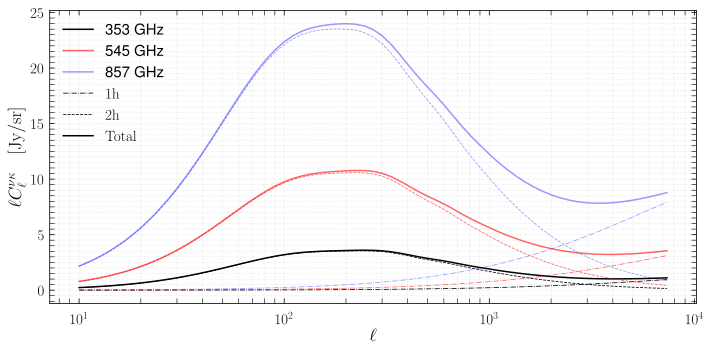

In [11]:
#Get Data
ells = np.asarray(Dl_lens_cib['545']['ell'])
factor = cl_to_dl(ells)

#Font Settings
label_size = 15
title_size = 18
legend_size = 13


fig, (ax1) = plt.subplots(1,1,figsize=(10,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

#Colors
colors = ['k','r','b']
alphas = [1,0.6,0.4]

for i, nu in enumerate(nu_list):
    #Extract Data
    nu_name = str(nu)
    cl_1h = np.asarray(Dl_lens_cib[str(nu)]['1h']) / factor
    cl_2h = np.asarray(Dl_lens_cib[str(nu)]['2h']) / factor
    cl_tot = cl_1h + cl_2h

    #Plot
    plt.plot(ells, ells * cl_tot, label= nu_name + ' GHz', color=colors[i],alpha= alphas[i])
    plt.plot(ells, ells * cl_1h, '-.', alpha= alphas[i], color=colors[i],lw=0.8)
    plt.plot(ells, ells * cl_2h, '--', alpha= alphas[i], color=colors[i],lw=0.8)

    #Figure Size
    # ax = plt.gca()
    # fig = plt.gcf()
    # fig.set_figheight(6)
    # fig.set_figwidth(11)
    

    #Legend
    line_1h = mpl.lines.Line2D([0], [0], label=r'$\mathrm{1h}$', color='black', linestyle='-.', lw=0.8)
    line_2h = mpl.lines.Line2D([0], [0], label=r'$\mathrm{2h}$', color='black', linestyle='--',lw=0.8)
    line_1p2h = mpl.lines.Line2D([0], [0], label=r'$\mathrm{Total}$', color='black', linestyle='-')
    h, l = ax.get_legend_handles_labels()
    h.extend([line_1h, line_2h,line_1p2h])
    plt.legend(handles= h,frameon=False,fontsize=15,loc=2)

    #Labels
    plt.xlabel(r'$\ell$', fontsize= title_size,labelpad=1)
    plt.ylabel(r'$\ell C^{\nu\kappa}_{\ell}$\quad$\mathrm{[Jy/sr]}$', size= title_size)
    plt.xscale('log')
    # plt.yscale('log')
    
    #Ticks
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax.tick_params(axis = 'x',which='both',length=5,direction='in', top=True, right=True, labelsize=label_size, pad=10)
    ax.tick_params(axis = 'y',which='both',length=5,direction='in', top=True, right=True, labelsize=label_size, pad=5)
    ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
    
plt.tight_layout()
# plt.savefig('figures/cls_CIB_CMB_lensing.pdf')

# No consistency

In [17]:
M = Class()

#Set Parameters
M.set(p14_dict)
M.set(p_hm_dict)
M.set(p_CIB_dict)
M.set(p_freq_dict)

#Tell It What You Want
M.set({
    'output': 'lens_cib_1h,lens_cib_2h',
    'hm_consistency':0,
})

True

In [19]:
%%time
#Calculate Spectra
M.compute_class_szfast()
Dl_lens_cib = M.cl_lens_cib()

CPU times: user 22.5 s, sys: 267 ms, total: 22.8 s
Wall time: 3.33 s


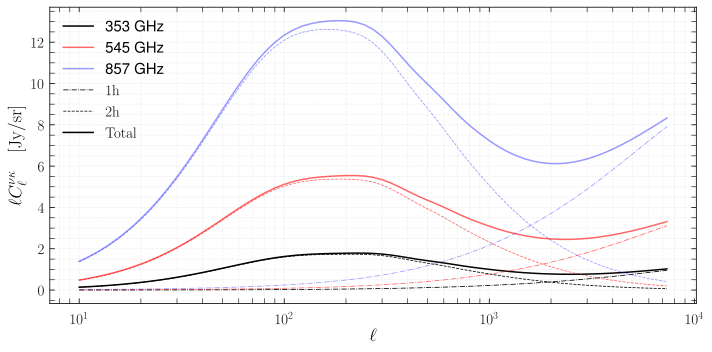

In [20]:
#Get Data
ells = np.asarray(Dl_lens_cib['545']['ell'])
factor = cl_to_dl(ells)

#Font Settings
label_size = 15
title_size = 18
legend_size = 13


fig, (ax1) = plt.subplots(1,1,figsize=(10,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

#Colors
colors = ['k','r','b']
alphas = [1,0.6,0.4]

for i, nu in enumerate(nu_list):
    #Extract Data
    nu_name = str(nu)
    cl_1h = np.asarray(Dl_lens_cib[str(nu)]['1h']) / factor
    cl_2h = np.asarray(Dl_lens_cib[str(nu)]['2h']) / factor
    cl_tot = cl_1h + cl_2h

    #Plot
    plt.plot(ells, ells * cl_tot, label= nu_name + ' GHz', color=colors[i],alpha= alphas[i])
    plt.plot(ells, ells * cl_1h, '-.', alpha= alphas[i], color=colors[i],lw=0.8)
    plt.plot(ells, ells * cl_2h, '--', alpha= alphas[i], color=colors[i],lw=0.8)

    #Figure Size
    # ax = plt.gca()
    # fig = plt.gcf()
    # fig.set_figheight(6)
    # fig.set_figwidth(11)
    

    #Legend
    line_1h = mpl.lines.Line2D([0], [0], label=r'$\mathrm{1h}$', color='black', linestyle='-.', lw=0.8)
    line_2h = mpl.lines.Line2D([0], [0], label=r'$\mathrm{2h}$', color='black', linestyle='--',lw=0.8)
    line_1p2h = mpl.lines.Line2D([0], [0], label=r'$\mathrm{Total}$', color='black', linestyle='-')
    h, l = ax.get_legend_handles_labels()
    h.extend([line_1h, line_2h,line_1p2h])
    plt.legend(handles= h,frameon=False,fontsize=15,loc=2)

    #Labels
    plt.xlabel(r'$\ell$', fontsize= title_size,labelpad=1)
    plt.ylabel(r'$\ell C^{\nu\kappa}_{\ell}$\quad$\mathrm{[Jy/sr]}$', size= title_size)
    plt.xscale('log')
    # plt.yscale('log')
    
    #Ticks
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax.tick_params(axis = 'x',which='both',length=5,direction='in', top=True, right=True, labelsize=label_size, pad=10)
    ax.tick_params(axis = 'y',which='both',length=5,direction='in', top=True, right=True, labelsize=label_size, pad=5)
    ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
    
plt.tight_layout()
plt.savefig('figures/cls_CIB_CMB_lensing_nocc.pdf')

## fNL cases

You cant use fast mode (need full transfer functions)

In [12]:
%%time
M = Class()

#Set Parameters
M.set(p14_dict)
M.set(p_hm_dict)
M.set(p_CIB_dict)
M.set(p_freq_dict)
#Calculate Spectra
M.set({
# 'ndim_redshifts':150,
'use scale dependent bias (from non Gaussianity)' : 1,
'fNL' : 100.,
'hm_consistency': 1,
'ndim_redshifts': 100,
'ndim_masses': 100,
})
#Tell It What You Want
M.set({
    'output': 'lens_cib_1h,lens_cib_2h'
})
M.compute()
Dl_lens_cib = M.cl_lens_cib()


CPU times: user 1min 2s, sys: 66.3 ms, total: 1min 2s
Wall time: 7.34 s


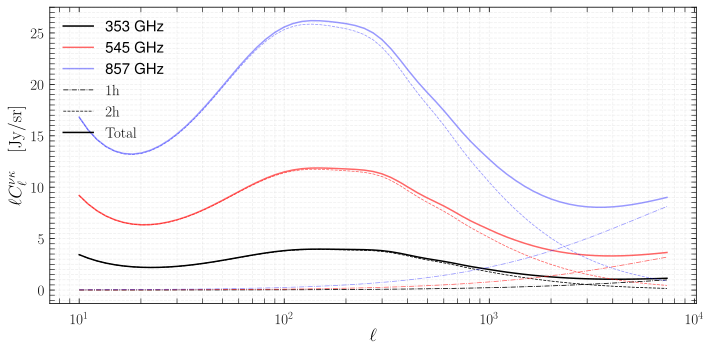

In [13]:
#Get Data
ells = np.asarray(Dl_lens_cib['545']['ell'])
factor = cl_to_dl(ells)

#Font Settings
label_size = 15
title_size = 18
legend_size = 13


fig, (ax1) = plt.subplots(1,1,figsize=(10,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

#Colors
colors = ['k','r','b']
alphas = [1,0.6,0.4]

for i, nu in enumerate(nu_list):
    #Extract Data
    nu_name = str(nu)
    cl_1h = np.asarray(Dl_lens_cib[str(nu)]['1h']) / factor
    cl_2h = np.asarray(Dl_lens_cib[str(nu)]['2h']) / factor
    cl_tot = cl_1h + cl_2h

    #Plot
    plt.plot(ells, ells * cl_tot, label= nu_name + ' GHz', color=colors[i],alpha= alphas[i])
    plt.plot(ells, ells * cl_1h, '-.', alpha= alphas[i], color=colors[i],lw=0.8)
    plt.plot(ells, ells * cl_2h, '--', alpha= alphas[i], color=colors[i],lw=0.8)

    #Figure Size
    # ax = plt.gca()
    # fig = plt.gcf()
    # fig.set_figheight(6)
    # fig.set_figwidth(11)
    

    #Legend
    line_1h = mpl.lines.Line2D([0], [0], label=r'$\mathrm{1h}$', color='black', linestyle='-.', lw=0.8)
    line_2h = mpl.lines.Line2D([0], [0], label=r'$\mathrm{2h}$', color='black', linestyle='--',lw=0.8)
    line_1p2h = mpl.lines.Line2D([0], [0], label=r'$\mathrm{Total}$', color='black', linestyle='-')
    h, l = ax.get_legend_handles_labels()
    h.extend([line_1h, line_2h,line_1p2h])
    plt.legend(handles= h,frameon=False,fontsize=15,loc=2)

    #Labels
    plt.xlabel(r'$\ell$', fontsize= title_size,labelpad=1)
    plt.ylabel(r'$\ell C^{\nu\kappa}_{\ell}$\quad$\mathrm{[Jy/sr]}$', size= title_size)
    plt.xscale('log')
    # plt.yscale('log')
    
    #Ticks
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax.tick_params(axis = 'x',which='both',length=5,direction='in', top=True, right=True, labelsize=label_size, pad=10)
    ax.tick_params(axis = 'y',which='both',length=5,direction='in', top=True, right=True, labelsize=label_size, pad=5)
    ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
    
plt.tight_layout()
# plt.savefig('figures/cls_CIB_CMB_lensing.pdf')

## compute many fnl's 

Initialize the cosmology:

In [17]:
%%time
M = Class()
#Set Parameters
M.set(p14_dict)
M.set(p_hm_dict)
M.set(p_CIB_dict)
M.set(p_freq_dict)
#Calculate Spectra
M.set({
# 'ndim_redshifts':150,
'use scale dependent bias (from non Gaussianity)' : 1,
'fNL' : 100.,
'hm_consistency': 1,
'ndim_redshifts': 100,
'ndim_masses': 100,
})
#Tell It What You Want
M.set({
    'output': 'lens_cib_1h,lens_cib_2h'
})
M.compute()

CPU times: user 1min 2s, sys: 95.5 ms, total: 1min 2s
Wall time: 7.28 s


Compute (without redoing cosmo)

In [19]:
%%time
## define array of fNL
fnl_ar = np.linspace(-100,100,10)
Dl_lens_cib_all = []
for fnl in fnl_ar:
    M.compute_class_sz({'fNL':fnl})
    Dl_lens_cib_all.append(M.cl_lens_cib())

CPU times: user 4min 24s, sys: 551 ms, total: 4min 24s
Wall time: 29.9 s


## plot

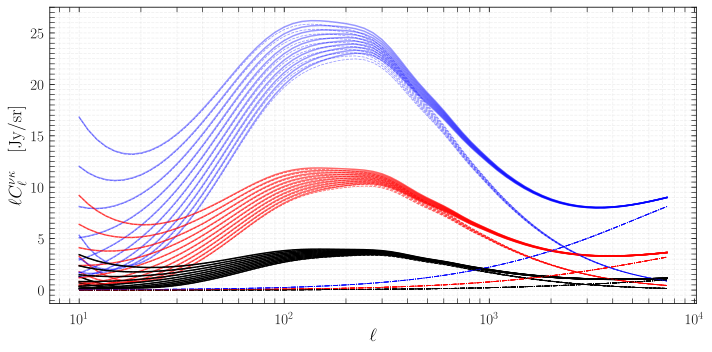

In [26]:
#Get Data
ells = np.asarray(Dl_lens_cib['545']['ell'])
factor = cl_to_dl(ells)

#Font Settings
label_size = 15
title_size = 18
legend_size = 13


fig, (ax1) = plt.subplots(1,1,figsize=(10,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

#Colors
colors = ['k','r','b']
alphas = [1,0.6,0.4]
for ifnl,fnl in enumerate(fnl_ar):
    Dl_lens_cib = Dl_lens_cib_all[ifnl]
    for i, nu in enumerate(nu_list):
        #Extract Data
        nu_name = str(nu)
        cl_1h = np.asarray(Dl_lens_cib[str(nu)]['1h']) / factor
        cl_2h = np.asarray(Dl_lens_cib[str(nu)]['2h']) / factor
        cl_tot = cl_1h + cl_2h

        #Plot
        plt.plot(ells, ells * cl_tot, label= nu_name + ' GHz', color=colors[i],alpha= alphas[i])
        plt.plot(ells, ells * cl_1h, '-.', alpha= alphas[i], color=colors[i],lw=0.8)
        plt.plot(ells, ells * cl_2h, '--', alpha= alphas[i], color=colors[i],lw=0.8)

        #Figure Size
        # ax = plt.gca()
        # fig = plt.gcf()
        # fig.set_figheight(6)
        # fig.set_figwidth(11)


        #Legend
        line_1h = mpl.lines.Line2D([0], [0], #label=r'$\mathrm{1h}$', 
                                   color='black', linestyle='-.', lw=0.8)
        line_2h = mpl.lines.Line2D([0], [0], #label=r'$\mathrm{2h}$', 
                                   color='black', linestyle='--',lw=0.8)
        line_1p2h = mpl.lines.Line2D([0], [0], #label=r'$\mathrm{Total}$', 
                                     color='black', linestyle='-')
        # h, l = ax.get_legend_handles_labels()
        h.extend([line_1h, line_2h,line_1p2h])
        # plt.legend(handles= h,frameon=False,fontsize=15,loc=2)

        #Labels
        plt.xlabel(r'$\ell$', fontsize= title_size,labelpad=1)
        plt.ylabel(r'$\ell C^{\nu\kappa}_{\ell}$\quad$\mathrm{[Jy/sr]}$', size= title_size)
        plt.xscale('log')
        # plt.yscale('log')

        #Ticks
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
        ax.tick_params(axis = 'x',which='both',length=5,direction='in', top=True, right=True, labelsize=label_size, pad=10)
        ax.tick_params(axis = 'y',which='both',length=5,direction='in', top=True, right=True, labelsize=label_size, pad=5)
        ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')

plt.tight_layout()
# plt.savefig('figures/cls_CIB_CMB_lensing.pdf')